# Análise de Sentimentos - PMR3508

**Aluno: Gustavo Nunes Ribeiro**


## 1. Importação de Bibliotecas

Inicia-se o processo de análise importanto as bibliotecas necessárias para o seu desenvolvimento.

Para a manipulação dos dados, importa-se as bibliotecas **numpy** e **pandas**.

In [1]:
import numpy as np
import pandas as pd

Para, possivelmente, visualizar os dados manipulados, utiliza-se a biblioteca **seaborn**.

In [2]:
import seaborn as sns

Para o processamento dos texto, utiliza-se as seguintes bibliotecas:

In [3]:
!pip install ftfy
!pip install gensim

     |████████████████████████████████| 64 kB 555 kB/s 
  Created wheel for ftfy: filename=ftfy-5.8-py3-none-any.whl size=45612 sha256=0221c82a70c99d6324a3e34a976f3d3e76d427d4ac3fec0b42c1e1fabd3cb3d0
  Stored in directory: /root/.cache/pip/wheels/49/1c/fc/8b19700f939810cd8fd9495ae34934b246279791288eda1c31
Successfully built ftfy
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2. Importação dos Dados


Para treinar o modelo, utiliza-se o Dataset de treino

In [4]:
train = pd.read_csv("../input/sentiment-analysis-pmr3508/data_train.csv")

Para visualizar a disposição dos dados importados, utiliza-se a função `head()`

In [5]:
train.head()

,review,positive
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


## 3. Pré-Processamento dos Dados

Como ação preventiva, droparemos, caso exista, todas a linhas duplicadas do Dataset.

In [6]:
train.shape

(24984, 2)

In [7]:

train = train.drop_duplicates(keep='first')
train.shape

(24888, 2)

Nota-se uma quantidade significativa de dados duplicados foram eliminados.

Além disso, analisa-se a distruibuição dos dados, se é balanceada ou não.

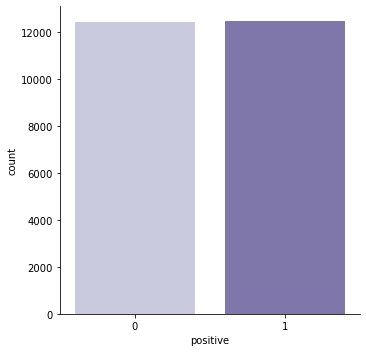

In [8]:
sns.catplot(x="positive", kind="count", palette="Purples", data=train)

Como pode ser observado, os dados estão distribuídos de forma igualitária, não havendo, portanto, necessidade de balanceá-los.

Em seguida, para preparar os dados que serão utilizados, é necessário tratá-los. A forma como será feita foi definida e disponibilizada pelo monitor da disciplina. Dentre as ações, pode-se destacar a tokenização do texto, a remoção de caractéres especiais e pontuações, a transformação para letras minúsculas, entre outras ações.

In [9]:
import re
import string
from ftfy import fix_text

def preptext(text):
    txt=text.replace("<br />"," ") #retirando tags
    txt=fix_text(txt) #consertando Mojibakes (Ver https://pypi.org/project/ftfy/)
    txt=txt.lower() #passando tudo para minúsculo
    txt=txt.translate(str.maketrans('', '', string.punctuation)) #retirando toda pontuação
    txt=txt.replace(" — ", " ") #retirando hífens
    txt=re.sub("\d+", ' <number> ', txt) #colocando um token especial para os números
    txt=re.sub(' +', ' ', txt) #deletando espaços extras
    return txt

Agora, dividi-se o dataset em duas partes, os atributos **X** e a classe **y**.

In [10]:
X_train = train['review']
y_train = train['positive']

In [11]:
X_train.head()

0    Bromwell High is a cartoon comedy. It ran at t...
1    Homelessness (or Houselessness as George Carli...
2    Brilliant over-acting by Lesley Ann Warren. Be...
3    This is easily the most underrated film inn th...
4    This is not the typical Mel Brooks film. It wa...
Name: review, dtype: object

Aplica-se, portanto, a função criada e obtêm-se os dados padronizados.

In [12]:
X_train = X_train.apply(preptext)
X_train.head()

0    bromwell high is a cartoon comedy it ran at th...
1    homelessness or houselessness as george carlin...
2    brilliant overacting by lesley ann warren best...
3    this is easily the most underrated film inn th...
4    this is not the typical mel brooks film it was...
Name: review, dtype: object

Para trabalhar com os dados obtidos, é necessário armazenar cada uma das palavras dentro de um vetor.

In [13]:
X_train = X_train.apply(lambda x: x.split())
X_train.head()

0    [bromwell, high, is, a, cartoon, comedy, it, r...
1    [homelessness, or, houselessness, as, george, ...
2    [brilliant, overacting, by, lesley, ann, warre...
3    [this, is, easily, the, most, underrated, film...
4    [this, is, not, the, typical, mel, brooks, fil...
Name: review, dtype: object

### 3. 1. Word Embedding 

Para utilizar as palavras, antes inseridas em vetores, é necessário transformá-las em vetores numéricos. Para isso, utiliza-se o modelo **Doc2Vec**. 


In [14]:
from gensim.models.doc2vec import Doc2Vec
d2v = Doc2Vec.load("../input/analise-sentimentos/doc2vec")

In [15]:
#Função disponibilizada no GitHub pelo Felipe Polo
def emb(txt, model, normalize=False): 
    model.random.seed(42)
    x=model.infer_vector(txt, steps=20)
    
    if normalize: return(x/np.sqrt(x@x))
    else: return(x)

Uma vez definida a função, a aplica-se ao nosso dataset.

In [16]:
X_train = X_train.to_list()
X_train = [emb(x, d2v) for x in X_train] 
X_train = np.array(X_train)
X_train.shape

(24888, 50)

In [17]:
X_train

array([[-0.19010174,  0.09099033, -0.81909645, ...,  0.4700647 ,
         0.6645498 ,  0.04297624],
       [ 0.45501634,  0.18242425, -1.777562  , ...,  0.12909065,
        -0.02368977,  1.4491358 ],
       [-0.5374058 ,  0.5839215 ,  0.3649743 , ..., -0.0648883 ,
         0.71846503,  0.0019397 ],
       ...,
       [-1.24933   , -0.7087177 , -0.5482241 , ..., -0.15500566,
        -0.1219629 , -0.2968659 ],
       [-0.19273654,  0.15433277, -0.3144202 , ...,  0.474921  ,
        -0.07705972, -0.166927  ],
       [-0.98778456,  0.47884825, -0.12010094, ..., -0.25440702,
         0.49671653,  0.13248508]], dtype=float32)

Como utilizaremos o mesmo processo na base de validação, faremos o processo para o dataset de treino.

In [18]:
test = pd.read_csv("../input/sentiment-analysis-pmr3508/data_test1.csv")

In [19]:
X_valid = valid['review'].tolist()
y_valid = valid['positive']

NameError: name 'valid' is not defined

In [20]:
X_valid = [clean(x).split() for x in X_valid]
X_valid = [emb(x, d2v) for x in X_valid] 
X_valid = np.array(X_valid)

NameError: name 'X_valid' is not defined

In [21]:
X_valid

NameError: name 'X_valid' is not defined

Uma vez com os dados processados, pode-se partir para a classificação.

## 4. Classificação

A seguir, utiliza-se diversos algoritmos de classificação.

### 4. 1. Rede neural (1 camada oculta)

Nesse caso, em que será projetada uma camada oculta de rede neural, utiliza-se a MLPClassifier do Scikit-Learn. Assim, otimiza-se a quantidade de neurônios na única camada escondida, o coeficiente de regularização e o tipo da taxa de aprendizado.

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform as sp_loguniform

# Modelo de Rede Neural de 1 camada escondida
mlp_1l = MLPClassifier(random_state=10, early_stopping=True)

# Hiperparâmetros a serem otimizados
hyperparams = {'hidden_layer_sizes': [(2 ** i) for i in np.arange(6, 12)],
               'alpha': sp_loguniform(0.000001, 0.1),
               'learning_rate': ['constant','adaptive']}

# Busca de Hiperparâmetros
mlp_clf_1l = RandomizedSearchCV(mlp_1l, hyperparams, scoring='roc_auc', n_iter=30, cv=2, n_jobs=-1, random_state=0, verbose=2)
search_mlp = mlp_clf_1l.fit(X_train, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.2min finished


Para otimizar os parâmetros, utiliza-se:


In [23]:
search_mlp.best_params_, search_mlp.best_score_

({'alpha': 0.003077201812975572,
  'hidden_layer_sizes': 128,
  'learning_rate': 'adaptive'},
 0.888881796852369)

### 4. 2. Rede neural (2 camada oculta)

Como esperado, testaremos o classificador com 2 camada ocultas, manipulando da mesma forma como foi feita anteriormente, utilizando a MLPClassifier do Scikit-Learn.

In [24]:
from sklearn.neural_network import MLPClassifier
from scipy.stats import loguniform as sp_loguniform

# Modelo de Rede Neural de 2 camadas escondidas
mlp_2l = MLPClassifier(random_state=42, early_stopping=True)

# Hiperparâmetros a serem otimizados
hyperparams = {'hidden_layer_sizes': [(2 ** i, 2 ** j) for j in np.arange(6, 10) for i in np.arange(6, 10)],
               'alpha': sp_loguniform(0.000001, 0.1),
               'learning_rate': ['constant','adaptive']}

# Busca de Hiperparâmetros
mlp_clf_2l = RandomizedSearchCV(mlp_2l, hyperparams, scoring='roc_auc', n_iter=25, cv=2, n_jobs=-1, random_state=0, verbose=2)
search_mlp = mlp_clf_2l.fit(X_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.1min finished


In [25]:
search_mlp.best_params_, search_mlp.best_score_

({'alpha': 0.0002029536243043474,
  'hidden_layer_sizes': (512, 64),
  'learning_rate': 'adaptive'},
 0.8905242855690323)

Como pôde ser constatado, o modelo utilizando 2 camadas ocultas obteve melhor resultado, como esperado.

### 4. 3. Rede neural (2 camadas ocultas) - Pytorch

Nesse modelo de classificação, utiliza-se framework Pytorch, muito utilizado em algoritmos de *DeepLearning*.

In [26]:
# Colocando uma seed para garantir reprodutibilidade
import torch
torch.manual_seed(42)

In [27]:
import torch.nn as nn
import torch.nn.functional as F

# Nossa rede neural
class MLPNet(nn.Module):
    def __init__(self, hidden1_dim=512, hidden2_dim=256, p=0.25):
        super().__init__()
        # Primeira camada escondida de tamanho 'hidden1_dim'
        self.fc1 = nn.Linear(50, hidden1_dim)
        
        # Segunda camada escondida de tamanho 'hidden2_dim'
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        
        # Camada de output de tamanho 2 (para as duas classes de target)
        self.fc3 = nn.Linear(hidden2_dim, 2)

        # Camada de Dropout para regularização
        self.dropout = nn.Dropout(p)
        
    def forward(self, X, **kwargs):
        # Aplicando a primeira camada escondida
        fc_out = F.relu(self.fc1(X))
        # Aplicando o Dropout
        fc_out = self.dropout(fc_out)
        
        # Aplicando a segunda camada escondida
        fc_out = F.relu(self.fc2(fc_out))
        # Aplicando o Dropout
        fc_out = self.dropout(fc_out)
        
        # Aplicando a camada de output
        fc_out = self.fc3(fc_out)
        # Obtendo as probabilidades de cada classe com um softmax
        soft_out = F.softmax(fc_out, dim=-1)
        
        return soft_out

In [28]:
import torch

# Instanciando a nossa rede
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mlp_net = MLPNet().to(device)

Para otimizar os hiperparâmetros, utilizaremos a biblioteca Skorch do Scikit-Learn.

In [29]:
!pip install skorch
!pip install scikit-learn==0.23.0

from numpy.ma import MaskedArray
import sklearn.utils.fixes

sklearn.utils.fixes.MaskedArray = MaskedArray

     |████████████████████████████████| 125 kB 916 kB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.3 MB 9.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

kmeans-smote 0.1.2 requires imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.7.0 which is incompatible.
kmeans-smote 0.1.2 requires numpy<1.16,>=1.13, but you'll have numpy 1.18.5 which is incompatible.
kmeans-smote 0.1.2 requires scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.23.

In [30]:
from torch import optim
from skorch import NeuralNetClassifier

# Criando uma Rede Neural do Skorch
skorch_net = NeuralNetClassifier(mlp_net,
                                 max_epochs=20,
                                 lr=1e-4,
                                 optimizer=optim.Adam,
                                 optimizer__weight_decay=1e-4,
                                 train_split=False,
                                 verbose=0,
                                 iterator_train__shuffle=True,
                                 )

Agora otimizaremos a rede do skorch, utilizando o scikit-learn, porém utilizando o BayesSearchCV.

In [31]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Hiperparâmetros a serem otimizados
hyperparams = {'module__hidden1_dim': Integer(256, 2048),
               'module__hidden2_dim': Integer(128, 512),
               'module__p': Real(0.1, 0.75, prior='uniform'),
               'optimizer__weight_decay': Real(1e-10, 1e-2, prior='log-uniform')}

# Busca de Hiperparâmetros
skorch_clf = BayesSearchCV(skorch_net, hyperparams, scoring='roc_auc', n_iter=40, cv=3, n_jobs=-1, random_state=42, verbose=0)
search_skorch = skorch_clf.fit(X_train.astype(np.float32), y_train.astype(np.int64))

In [32]:
search_skorch.best_params_, search_skorch.best_score_

(OrderedDict([('module__hidden1_dim', 1578),
              ('module__hidden2_dim', 128),
              ('module__p', 0.5327401225433677),
              ('optimizer__weight_decay', 2.136414491343834e-09)]),
 0.8945960974556169)

### 4.4. KNN

Como método comparativo, implementa-se o KNN do scikit-learn.

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=20)
score_numeric = cross_val_score(knn, X_train, y_train, cv=10)
print(score_numeric)

[0.77460828 0.75371635 0.76576939 0.78344717 0.76295701 0.75532342
 0.75090398 0.76657292 0.76768489 0.75602894]


In [34]:
from sklearn.metrics import roc_auc_score
knn.fit(X_train, y_train)
knn_pred = knn.predict_proba(X_test)[:,1]
roc_auc_score(y_test, knn_pred)

NameError: name 'X_test' is not defined

## 5. Comparação dos classificadores

Para estabelecer uma comparação para os diferente classificadores utilizados, utilizaremos as AUC's aplicadas ao dados de validação do modelo

### 5. 1. Rede neural (1 camada oculta)

In [35]:
from sklearn.metrics import roc_auc_score

# Calculando a AUC da rede neural de 1 camada do sklearn
mlp_1l_roc_auc = roc_auc_score(y_test, mlp_clf_1l.predict_proba(X_test)[:,1])

print('AUCs --- MLP (1 camada): {:.4f}'.format(mlp_1l_roc_auc))

NameError: name 'y_test' is not defined

### 5. 2. Rede neural (2 camadas ocultas)

In [36]:
from sklearn.metrics import roc_auc_score

# Calculando a AUC da rede neural de 2 camadas do sklearn
mlp_2l_roc_auc = roc_auc_score(y_test, mlp_clf_2l.predict_proba(X_test)[:,1])

print('AUCs --- MLP (2 camadas): {:.4f}'.format(mlp_2l_roc_auc))

NameError: name 'y_test' is not defined

### 5. 3. Rede neural (2 camadas ocultas) - Pytorch

In [37]:
from sklearn.metrics import roc_auc_score

# Calculando a AUC da rede neural do Skorch
skorch_roc_auc = roc_auc_score(y_test, search_skorch.predict_proba(X_test)[:,1])

print('AUCs --- MLP (Skorch): {:.4f}'.format(skorch_roc_auc))

NameError: name 'y_test' is not defined

### 5. 4. KNN

In [38]:
roc_auc_score(y_test, knn_pred)

NameError: name 'y_test' is not defined

Como constatado numéricamente, o melhor resultado (AUC ) foi obtido pela rede neural do Pytorch

## 6.Submissão dos dados 

Importamos o dataset de test.

In [39]:
test = pd.read_csv("../input/sentiment-analysis-pmr3508/data_test2_X.csv")

Aplicamos os processos feitos no pré-processamento dos dados.

In [40]:
X_predict = test['review'].tolist()
X_predict = [preptext(x).split() for x in X_predict]
X_predict = [emb(x, d2v) for x in X_predict] 
X_predict = np.array(X_predict)

Então, aplicamos o modelo de rede neural.

In [41]:
prediction = search_skorch.predict_proba(X_predict)[:,1]

In [42]:
prediction

array([0.0006905 , 0.47211865, 0.00264302, ..., 0.01366333, 0.1017729 ,
       0.43044034], dtype=float32)

Por fim, para submete-lo ao Kaggle.

In [43]:
sub={'positive': prediction}
sub=pd.DataFrame(sub)

sub.head(15)

,positive
0,0.000691
1,0.472119
2,0.002643
3,0.141318
4,0.089437
5,0.502346
6,0.048714
7,0.613221
8,0.908360
9,0.733542


In [44]:
sub.to_csv("submission.csv", index = True, index_label = 'Id')